In [1]:
# Imports (External)
import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import copy

import sys
sys.path.append('../')  

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec, waverec
from scipy import signal
from statsmodels.robust import mad

# Internal Imports
from wsae_lstm.utils import dictmap_load,pickle_load,pickle_save

In [2]:
#plt.rcParams["figure.figsize"] = (10,6)

In [3]:
dict_dataframes_index=pickle_load(path_filename="../data/interim/cdii_tvt_split.pickle")
dict_dataframes_index.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [4]:
# [index data][period 1-24][train/validate/test]
    # Train [1], Validate [2], Test [3]
dict_dataframes_index['csi300 index data'][1][1].head(2)

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
date,,,,,,,,,,,,,,,,,,,
2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08


In [5]:
len(dict_dataframes_index['csi300 index data'][1][1])

489

In [6]:
len(dict_dataframes_index['csi300 index data'][1][1].columns)

19

In [7]:
data = dict_dataframes_index['csi300 index data'][1][1]
data.shape[1]

19

In [8]:
# # Multi-level wavelet transform
#     # https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#pywt.wavedec
# w = pywt.Wavelet('haar')
# coeffs = wavedec(data, w, level=2,axis=0)
# cA2, cD2, cD1 = coeffs
# # cA = Approximation coefficients
#     # Approximation (low pass)
# # cD = Detail coefficient(s)
#     # Detail (high pass)
#     # Detail cofficients represent the high freq part of the signal  

In [9]:
# http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
# https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes

def waveletSmooth( x, wavelet="haar", level=2, declevel=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode='periodization',level=declevel,axis=0 )
    # calculate a threshold
    sigma = mad(coeff[-level])
    #print(sigma)
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode='periodization',axis=0 )
    return y

In [10]:
################################################################################################

In [11]:
#dict_dataframes_index.keys()

In [12]:
# [index data][period 1-24][train/validate/test]
    # Train [1], Validate [2], Test [3]
dict_dataframes_index['csi300 index data'][1][1].head(2)

,open,high,low,close,volume,us dollar index,shibor,macd,cci,atr,boll,ema20,ma10,mtm6,ma5,mtm12,roc,smi,wvad
date,,,,,,,,,,,,,,,,,,,
2008-07-01,2799.20,2809.38,2690.18,2698.35,288515.85,72.34,2.5006,-213.078565,-128.949052,119.200,3173.475692,3033.748201,2851.2504,-91.594,2851.3262,-280.770,-9.424605,-0.097927,-8.726278e+07
2008-07-02,2702.63,2745.94,2670.06,2699.60,279163.65,71.99,2.7238,-213.732249,-139.719688,75.875,3140.413385,3001.924277,2822.0828,-152.318,2797.3382,-252.645,-8.557733,-0.026497,-1.095493e+08


In [13]:
for key, value in enumerate(dict_dataframes_index):
    print(value)

csi300 index data
nifty 50 index data
hangseng index data
nikkei 225 index data
s&p500 index data
djia index data


In [14]:
def denoise_periods(dict_dataframes):
    ddi_denoised= dict() 
    for key, index_name in enumerate(dict_dataframes):
        ddi_denoised[index_name] = copy.deepcopy(dict_dataframes[index_name])
    for key, index_name in enumerate(ddi_denoised):    
        for index,value in enumerate(ddi_denoised[index_name]):
            ddi_denoised[index_name][value][1]= waveletSmooth(ddi_denoised[index_name][value][1].values);
            ddi_denoised[index_name][value][2] = waveletSmooth(ddi_denoised[index_name][value][2].values);
            ddi_denoised[index_name][value][3] = waveletSmooth(ddi_denoised[index_name][value][3].values);
    return ddi_denoised

ddi_denoised=denoise_periods(dict_dataframes_index)
pickle_save(ddi_denoised,path_filename="../data/interim/cdii_tvt_split_denoised")

C:\Users\tyu-dev\Anaconda3\envs\wsae-lstm\lib\site-packages\pywt\_thresholding.py:23: RuntimeWarning: invalid value encountered in true_divide
  thresholded = (1 - value/magnitude)


In [15]:
ddi_denoised=pickle_load(path_filename="../data/interim/cdii_tvt_split_denoised.pickle")

In [16]:
len(ddi_denoised)

6

In [17]:
ddi_denoised.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

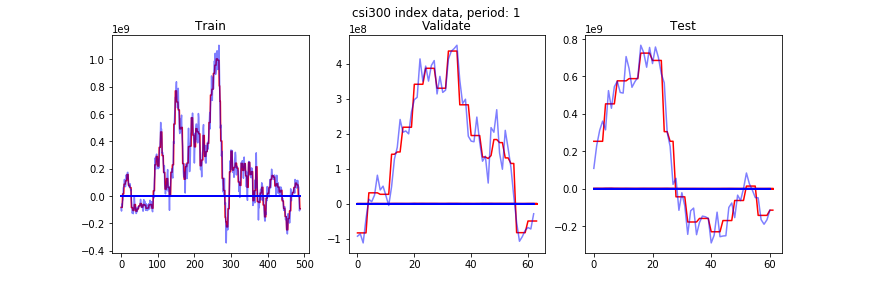

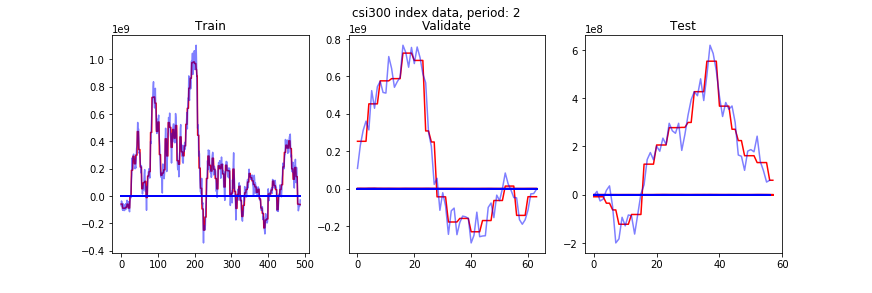

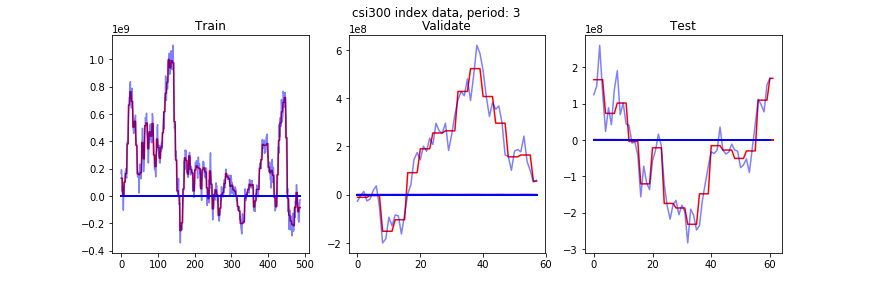

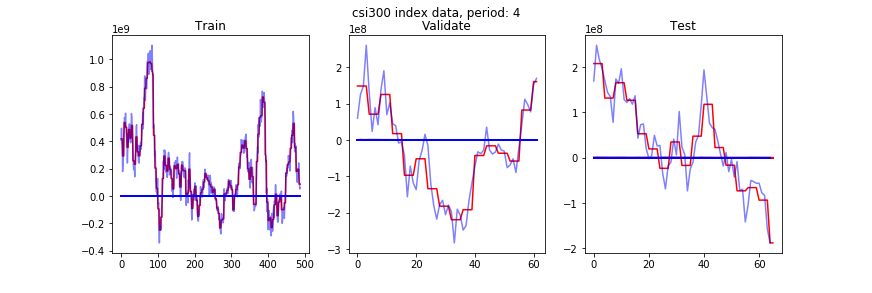

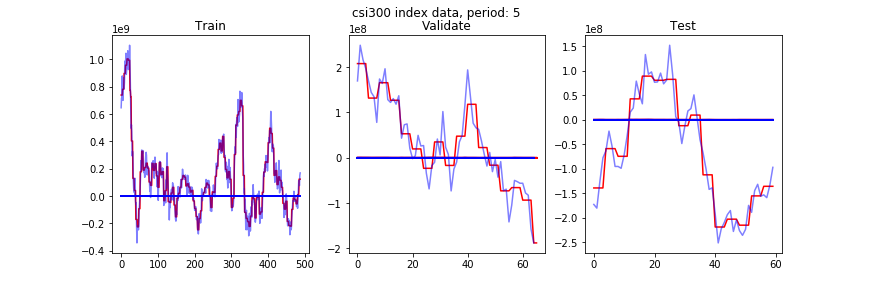

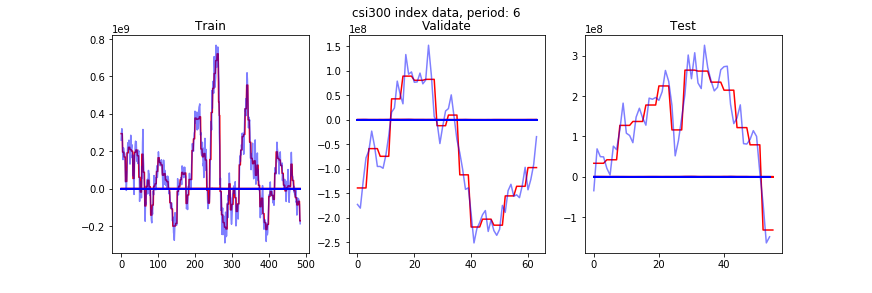

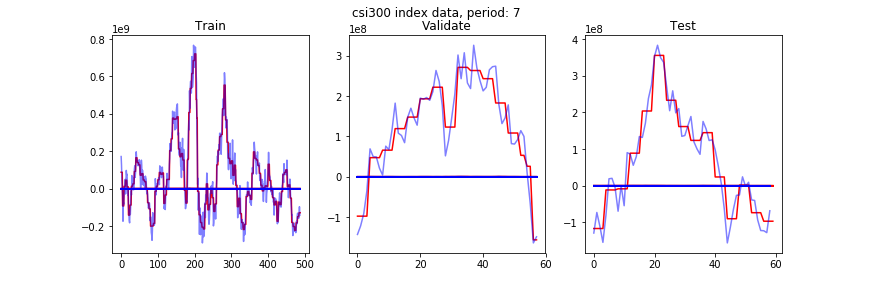

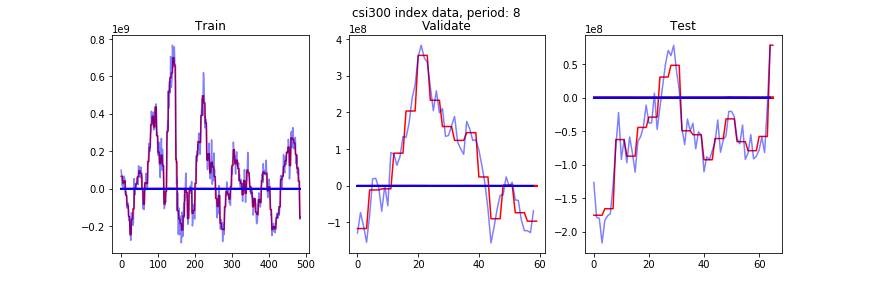

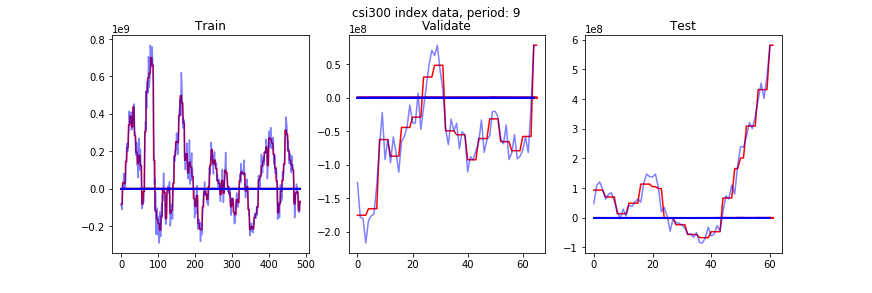

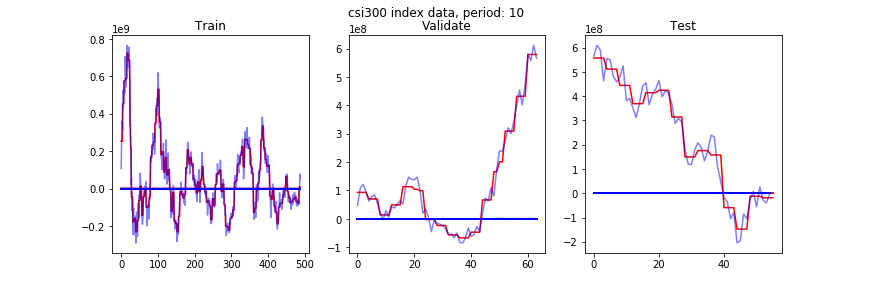

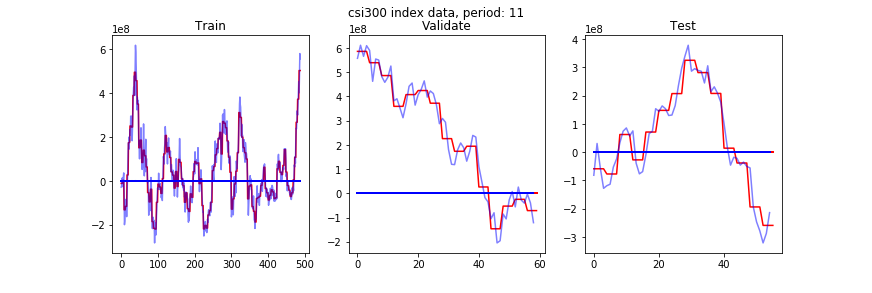

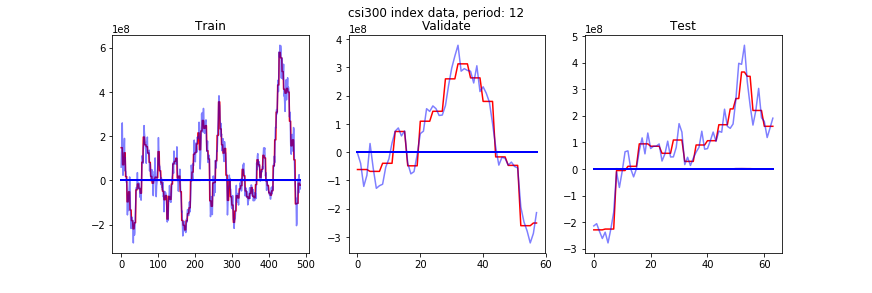

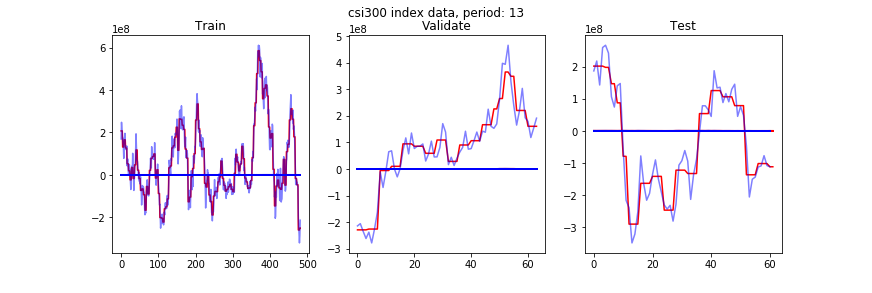

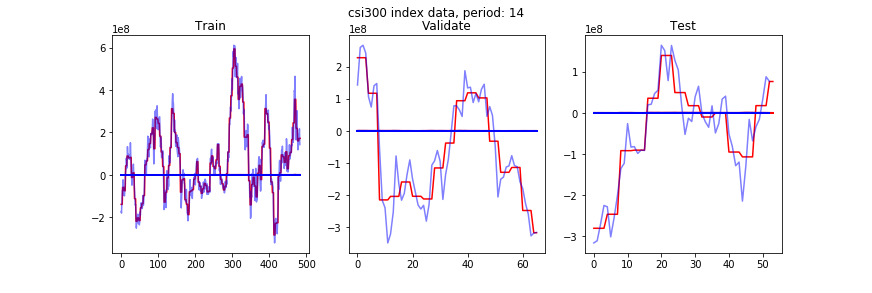

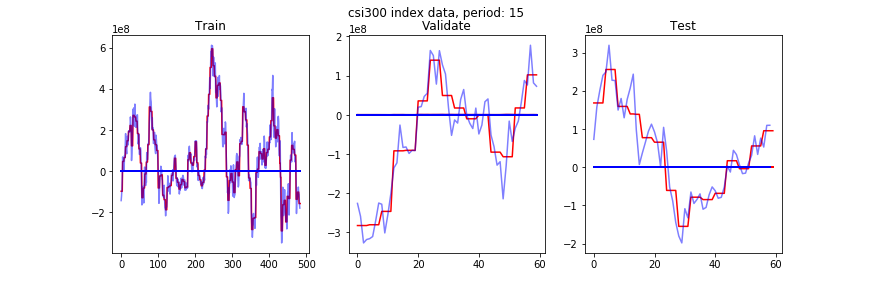

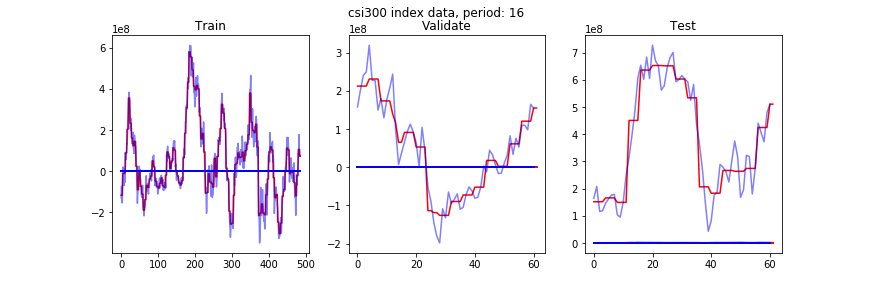

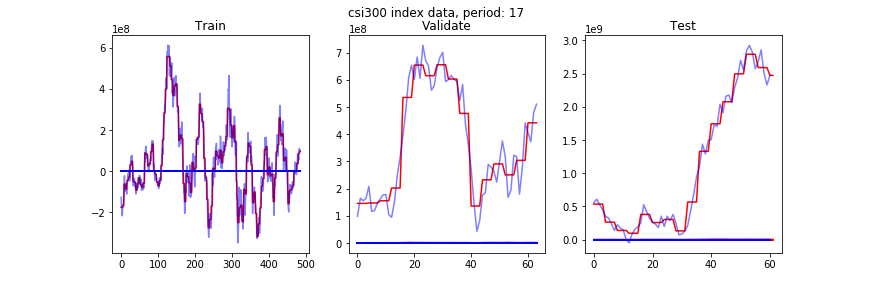

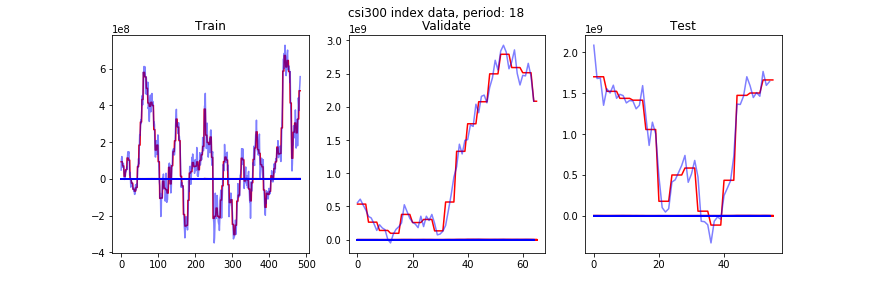

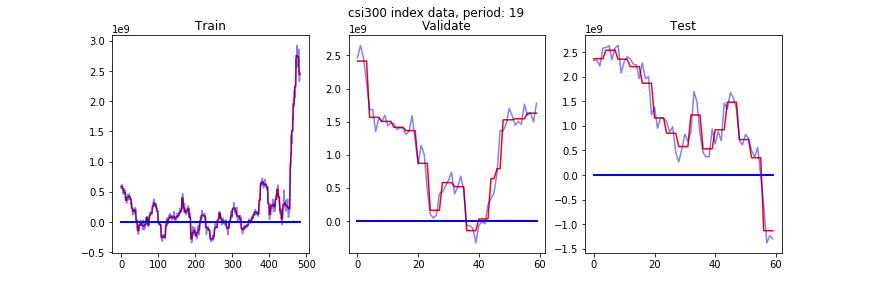

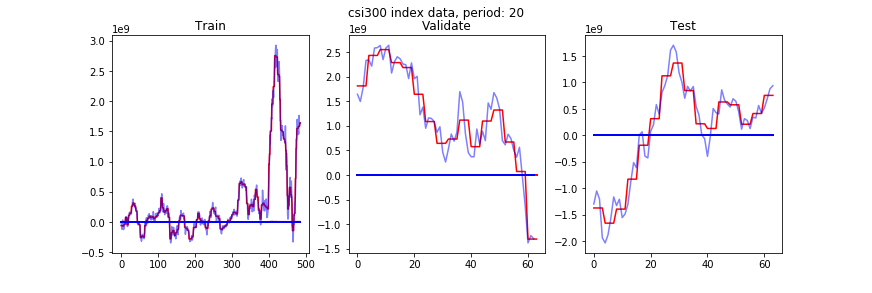

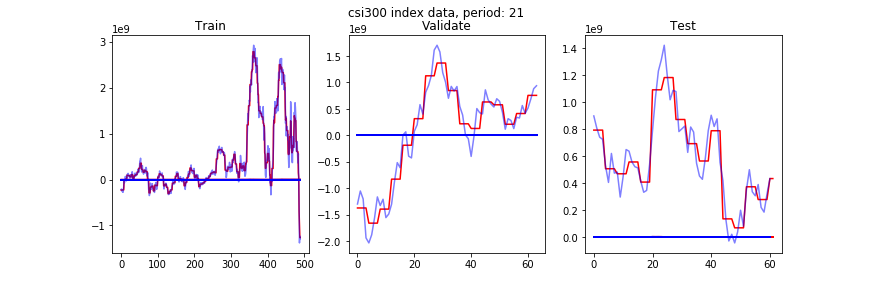

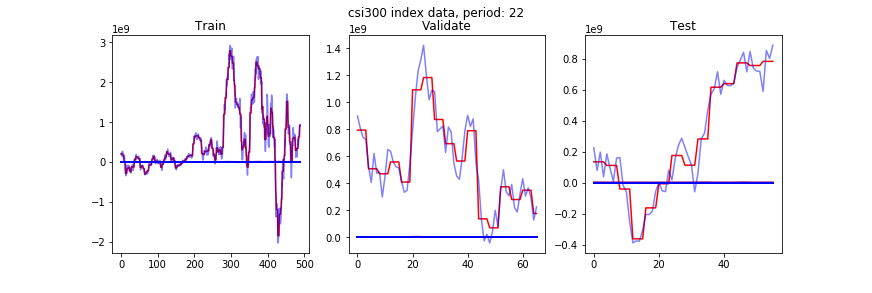

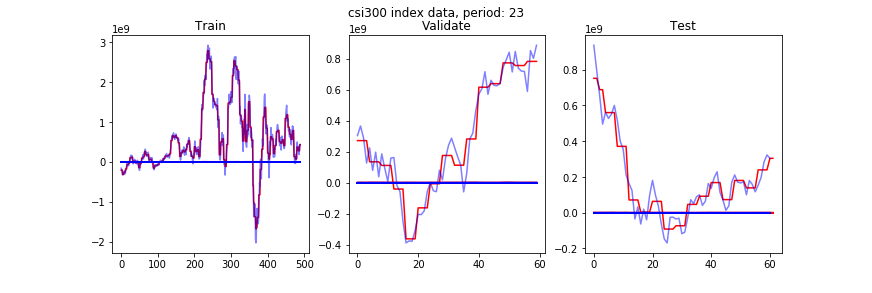

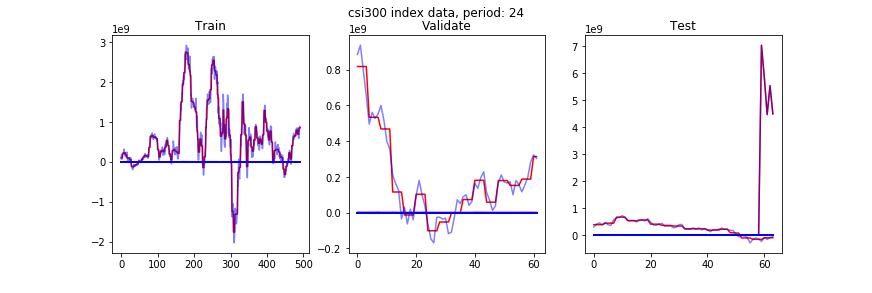

In [30]:
for index,value in enumerate(dict_dataframes_index['csi300 index data']): 
    #print("Period:",value)
    
    fig, axes= plt.subplots(1, 3,constrained_layout=True,figsize=(12,4))
 
    fig.suptitle('csi300 index data, period: {}'.format(value))
    fig.subplots_adjust(top=0.88)
    
    axes[0].set_title('Train')
    axes[0].plot(ddi_denoised['csi300 index data'][value][1],'r',label='denoised train data');
    axes[0].plot(dict_dataframes_index['csi300 index data'][value][1].values,'b',alpha=0.5, label='train data');

    axes[1].set_title('Validate')
    axes[1].plot(ddi_denoised['csi300 index data'][value][2],'r',label='denoised validate data');
    axes[1].plot(dict_dataframes_index['csi300 index data'][value][2].values,'b',alpha=0.5,label='validate data');

    axes[2].set_title('Test')
    axes[2].plot(ddi_denoised['csi300 index data'][value][3],'r',label='denoised test data');
    axes[2].plot(dict_dataframes_index['csi300 index data'][value][3].values,'b',alpha=0.5,label='test data');
    #plt.legend()
    #plt.tight_layout()
    plt.show()

In [19]:
#denoised_data_train = waveletSmooth(dict_dataframes_index['csi300 index data'][1][1].values);
#denoised_data_validate = waveletSmooth(dict_dataframes_index['csi300 index data'][1][2].values);
#denoised_data_test = waveletSmooth(dict_dataframes_index['csi300 index data'][1][3].values);


# fig, axes= plt.subplots(1, 3,constrained_layout=True,figsize=(12,4))
# axes[0].set_title('Train')
# axes[0].plot(denoised_data_train,'r',label='denoised train data');
# axes[0].plot(dict_dataframes_index['csi300 index data'][1][1].values,'b',alpha=0.5, label='train data');

# axes[1].set_title('Validate')
# axes[1].plot(denoised_data_validate,'r',label='denoised validate data');
# axes[1].plot(dict_dataframes_index['csi300 index data'][1][2].values,'b',alpha=0.5,label='validate data');

# axes[2].set_title('Test')
# axes[2].plot(denoised_data_test,'r',label='denoised test data');
# axes[2].plot(dict_dataframes_index['csi300 index data'][1][3].values,'b',alpha=0.5,label='test data');
# #plt.legend()
# plt.tight_layout()
# plt.show()

In [20]:
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())